TensorFlow: 2.12.0
Total samples: 23
split
train    18
test      3
val       2
Name: count, dtype: int64
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________
Epoch 1/8
2/2 [==============================] - 12s 3s/step - loss: 0.6817 - accuracy: 0.6111 - f1_score: 0.6957 - val_loss: 0.6951 - val_accuracy: 0.5000 - val_f1_score: 0.6667
Epoch 2/8
2/2 [=====

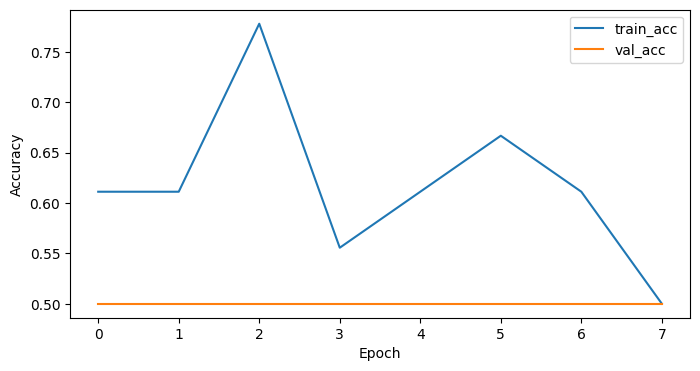

In [ ]:
# 06_train_image_model.ipynb
# --------------------------------------------------
import os
os.chdir(r"C:\Users\Negar\Desktop\paper_results\Myself\cr_coad_project")
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------------------------------
# CONFIG
DATA_DIR = Path("data/processed/images/rep_slices")
INDEX = Path("data/processed/images/rep_index.csv")
SPLIT_DIR = Path("data/splits")
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
EPOCHS = 8
# --------------------------------------------------

print("TensorFlow:", tf.__version__)
df = pd.read_csv(INDEX)
print("Total samples:", len(df))

# Load split IDs
train_ids = pd.read_csv(SPLIT_DIR / "train_series.csv")["series_id"].tolist()
val_ids   = pd.read_csv(SPLIT_DIR / "val_series.csv")["series_id"].tolist()
test_ids  = pd.read_csv(SPLIT_DIR / "test_series.csv")["series_id"].tolist()

# Attach split info
def assign_split(row):
    sid = row["series_id"]
    if sid in train_ids: return "train"
    if sid in val_ids:   return "val"
    if sid in test_ids:  return "test"
    return "ignore"

df["split"] = df.apply(assign_split, axis=1)
df = df[df["split"] != "ignore"]
print(df["split"].value_counts())

# Label: 0=non-metastatic, 1=metastatic (we'll simulate random labels for now)
# Later, you will merge metastasis_status from patients_master.csv
df["label"] = np.where(np.arange(len(df)) % 2 == 0, 1, 0)

# --------------------------------------------------
# DATA PIPELINE
def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_dataset(subdf, augment=False):
    paths = subdf["rep_slice"].astype(str).tolist()
    labels = subdf["label"].astype(int).tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, y: (decode_img(p), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    return ds.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(df[df.split=="train"], augment=True)
val_ds   = make_dataset(df[df.split=="val"])
test_ds  = make_dataset(df[df.split=="test"])

# --------------------------------------------------
# MODEL
base = tf.keras.applications.EfficientNetB0(
    include_top=False, input_shape=IMG_SIZE+(3,), weights="imagenet", pooling="avg"
)
base.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tfa.metrics.F1Score(num_classes=1, threshold=0.5, average="micro")]
)

model.summary()

# --------------------------------------------------
# TRAIN
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# --------------------------------------------------
# EVALUATE
results = model.evaluate(test_ds, return_dict=True)
print("Test metrics:", results)

# --------------------------------------------------
# SAVE WEIGHTS ONLY (skip full model serialization)
from pathlib import Path
import pandas as pd

Path("results/images").mkdir(parents=True, exist_ok=True)

# Save only the learned parameters
model.save_weights("results/images/baseline_image_weights_only.h5")

# Save training history for plotting later
pd.DataFrame(history.history).to_csv("results/images/training_history.csv", index=False)

print("✅ Model weights + training history saved safely (no JSON serialization).")


# --------------------------------------------------
# PLOT TRAINING CURVES
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()
